# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vega
import json
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from utils import *

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 1min 19s, sys: 6.41 s, total: 1min 26s
Wall time: 1min 27s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 50.6 s, sys: 320 ms, total: 50.9 s
Wall time: 51 s


In [6]:
%%time
path = os.path.join('download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

# Select acronym_x and n_mutations_log1p covariates only
selected_cols = [col for col in covariates.columns if 'acronym_' in col]
selected_cols.append('n_mutations_log1p')
covariates = covariates[selected_cols]

CPU times: user 30 ms, sys: 10 ms, total: 40 ms
Wall time: 42 ms


In [7]:
y = Y[GENE]

In [8]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [9]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Pre-process data set
TODO: currently running PCA on both train and test partitions

In [10]:
# Pre-process expression data for use later
n_components = 100
scaled_expression = StandardScaler().fit_transform(expression)
pca = PCA(n_components).fit(scaled_expression)
explained_variance = pca.explained_variance_
expression_pca = pca.transform(scaled_expression)
expression_pca = pd.DataFrame(expression_pca)
expression_pca = expression_pca.set_index(expression.index.values)

In [11]:
print('fraction of variance explained: ' + str(pca.explained_variance_ratio_.sum()))

fraction of variance explained: 0.704813487369


In [12]:
# Create full feature matrix (expression + covariates)
X = pd.concat([covariates,expression_pca],axis=1)
print('Gene expression matrix shape: {0[0]}, {0[1]}'.format(expression.shape))
print('Full feature matrix shape: {0[0]}, {0[1]}'.format(X.shape))

Gene expression matrix shape: 7306, 20468
Full feature matrix shape: 7306, 133


## Set aside 10% of the data for testing

In [13]:
# Typically, this can only be done where the number of mutations is large enough
train_index, test_index = next(ShuffleSplit(n_splits=2, test_size=0.1, random_state=0).split(y))

X_partitions = {
    'full': {
        'train': X.ix[train_index], 
        'test': X.ix[test_index]
        },
    'expressions': {
        'train': expression_pca.ix[train_index], 
        'test': expression_pca.ix[test_index]
        },
    'covariates': {
        'train': covariates.ix[train_index], 
        'test': covariates.ix[test_index]
        }    
    } 

y_train = y[train_index]
y_test = y[test_index]

'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(
    len(X_partitions['full']['train'].columns), 
    len(X_partitions['full']['train']), 
    len(X_partitions['full']['test']))

'Size: 133 features, 6,575 training samples, 731 testing samples'

## Define pipeline and Cross validation model fitting

In [14]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0, 0.2, 0.8, 1],
}

pipeline = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

models = ['full', 'expressions', 'covariates']

cv_pipelines = {mod: GridSearchCV(estimator=pipeline, 
                             param_grid=param_grid, 
                             n_jobs=1, 
                             scoring='roc_auc') for mod in models}

In [15]:
%%time
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    pipeline.fit(X=X_partitions.get(model).get('train'), y=y_train)
# cv_pipeline_full.fit(X=X_train_full, y=y_train)

Fitting CV for model: full
Fitting CV for model: expressions
Fitting CV for model: covariates
CPU times: user 6.85 s, sys: 14.8 s, total: 21.6 s
Wall time: 5.48 s


In [16]:
# Best Params
for model, pipeline in cv_pipelines.items():
    print('{0}: {1:.3%}'.format(model, pipeline.best_score_))

    # Best Params
    print(pipeline.best_params_)

full: 92.509%
{'classify__alpha': 0.1, 'classify__loss': 'log', 'classify__l1_ratio': 0, 'classify__penalty': 'elasticnet'}
expressions: 91.953%
{'classify__alpha': 0.1, 'classify__loss': 'log', 'classify__l1_ratio': 0, 'classify__penalty': 'elasticnet'}
covariates: 84.259%
{'classify__alpha': 0.1, 'classify__loss': 'log', 'classify__l1_ratio': 0, 'classify__penalty': 'elasticnet'}


## Visualize hyperparameters performance

In [17]:
cv_results_df_dict = {model: 
    pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params']),
    ], axis='columns') for model, pipeline in cv_pipelines.items()}

model = 'full'

cv_results_df_dict[model].head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,params,rank_test_score,...,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,0.033993,0.003340,0.888238,0.904831,0.001,0,log,elasticnet,"{'classify__alpha': 0.001, 'classify__loss': '...",11,...,0.891642,0.907844,0.003289,0.000024,0.004001,0.007707,0.001,0.0,log,elasticnet
1,0.041852,0.003417,0.900355,0.914569,0.001,0.2,log,elasticnet,"{'classify__alpha': 0.001, 'classify__loss': '...",9,...,0.899128,0.916507,0.005402,0.000211,0.002952,0.003753,0.001,0.2,log,elasticnet


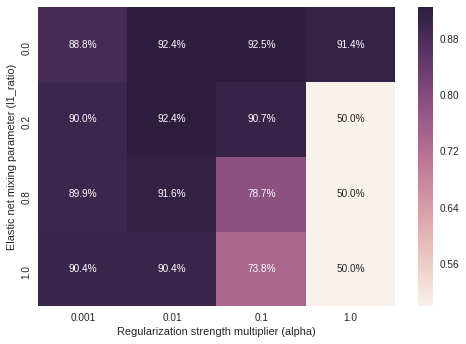

In [18]:
# Cross-validated performance heatmap
model = 'full'

cv_score_mat = pd.pivot_table(cv_results_df_dict[model],
                              values='mean_test_score', 
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [19]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_partitions[model]['train']),
        'test':  pipeline.decision_function(X_partitions[model]['test'])
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

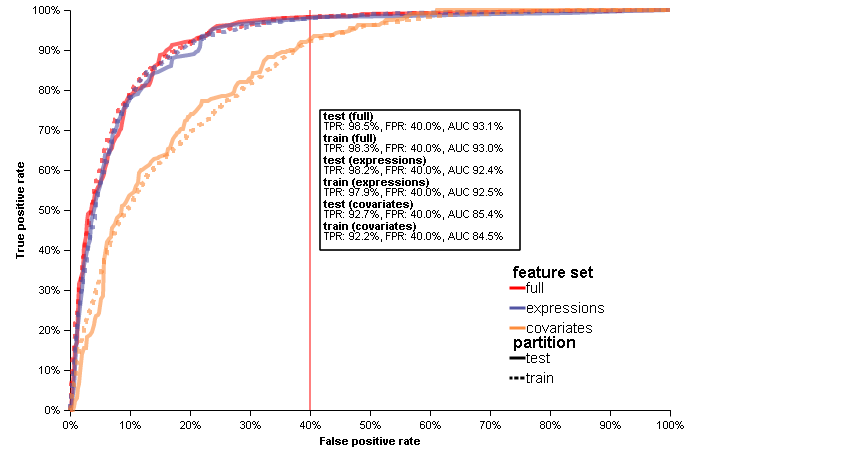

In [20]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc']
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))
auc_output['legend_index'] = range(len(auc_output.index))

with open('vega_specs/roc_vega_spec.json', 'r') as fp:
    vega_spec = json.load(fp)

final_spec = fill_spec_with_data(vega_spec, 
    {'roc': roc_output, 'legend_auc': auc_output})

vega.Vega(final_spec)

## What are the classifier coefficients?

In [21]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

In [22]:
def get_coefficients(classifier, X_mat):
    coef_df = pd.DataFrame.from_items([
        ('feature', X_mat.columns),
        ('weight', classifier.coef_[0]),
    ])

    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    return coef_df

coef_df_dict = {
    model: get_coefficients(classifier, X_partitions[model]['train'])
    for model, classifier in final_classifiers.items()
}

In [23]:
model = 'full'

print('{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df_dict[model].weight == 0).mean(),
    (coef_df_dict[model].weight < 0).sum(),
    (coef_df_dict[model].weight > 0).sum()
))
coef_df_dict[model].head(10)

0.0% zero coefficients; 64 negative and 69 positive coefficients


,feature,weight,abs
35,2,-0.341833,0.341833
32,n_mutations_log1p,0.322635,0.322635
44,11,-0.276991,0.276991
57,24,0.256559,0.256559
71,38,0.248938,0.248938
62,29,0.235922,0.235922
33,0,-0.207373,0.207373
67,34,-0.206373,0.206373
64,31,-0.194930,0.194930
27,acronym_THCA,-0.193992,0.193992


## Investigate the predictions

In [24]:
model = 'full'

X_all = X_partitions[model]['train'].append(X_partitions[model]['test'])
X_test_index = X_partitions[model]['test'].index
y_all = y_train.append(y_test)

predict_df = pd.DataFrame.from_items([
    ('sample_id', X_all.index),
    ('testing', X_all.index.isin(X_test_index).astype(int)),
    ('status', y_all),
    ('decision_function', final_pipelines[model].decision_function(X_all)),
    ('probability', final_pipelines[model].predict_proba(X_all)[:, 1])
])

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [25]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,3.667340,0.975092,97.5%
TCGA-EI-6513-01,TCGA-EI-6513-01,1,0,3.498110,0.970634,97.1%
TCGA-22-4591-01,TCGA-22-4591-01,0,0,3.362317,0.966506,96.7%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,3.098982,0.956851,95.7%
TCGA-RE-A7BO-01,TCGA-RE-A7BO-01,0,0,2.704246,0.937277,93.7%
TCGA-46-3765-01,TCGA-46-3765-01,0,0,2.615647,0.931862,93.2%
TCGA-BA-5149-01,TCGA-BA-5149-01,0,0,2.596403,0.930630,93.1%
TCGA-21-1081-01,TCGA-21-1081-01,0,0,2.585221,0.929904,93.0%
TCGA-24-2298-01,TCGA-24-2298-01,0,0,2.565446,0.928604,92.9%


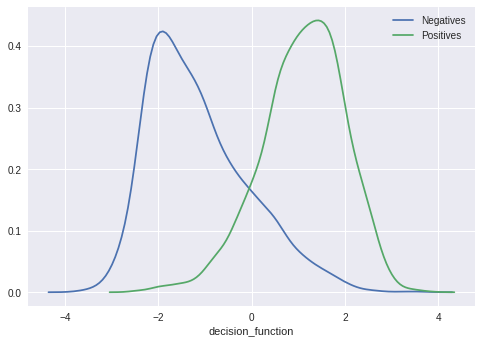

In [26]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

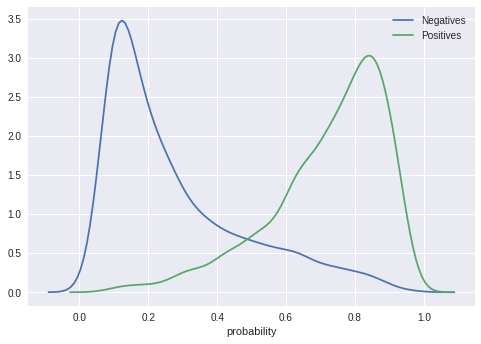

In [27]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')